In [1]:
import json
import pandas as pd

repo_profiles = {}
repo_teams = {}
with open('repo_profiles_new.json') as rj:
    for rl in rj.readlines():
        line = rl.split('\t')
        repo = line[0]
        profile = json.loads(line[1])
        repo_profiles[repo] = profile
        repo_teams[repo] = repo_profiles[repo].pop('teams')
    
team_profiles = []
teams = []
with open('team_profiles.json') as tj:
    for tl in tj.readlines():
        line = tl.split('\t')
        team = line[0]
        profile = json.loads(line[1])
        team_profiles.append(profile)
        teams.append(team)

In [2]:
repo_profiles_df = pd.DataFrame(repo_profiles).transpose()
repo_profiles_df.fillna('',inplace=True)
team_profiles_df = pd.DataFrame(team_profiles,index=teams)
team_profiles_df.rename(columns={
                                   'repo_size':'size',
                                   'repo_forks':'forks',
                                   'repo_subscribers':'subscribers',
                                   'repo_watchers':'watchers',
                                   'languages':'languages',
                                   'topics':'topics'
                               },inplace=True)

numerics = ['size','forks','subscribers','watchers']

In [3]:
repo_profiles_df[numerics].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B88BAB0C08>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B893851548>,
      dtype=object)

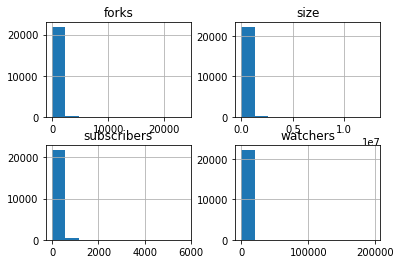

In [4]:
team_profiles_df[numerics].hist()

In [5]:
minn = repo_profiles_df[numerics].min()
maxx = repo_profiles_df[numerics].max()
repo_profiles_df[numerics] = (repo_profiles_df[numerics]-minn)/(maxx-minn)
team_profiles_df[numerics] = (team_profiles_df[numerics]-minn)/(maxx-minn)

print(repo_profiles_df.iloc[0])
print(team_profiles_df.iloc[0])

size            4.0849e-05
watchers                 0
forks                    0
subscribers    0.000116741
languages      [HTML, CSS]
topics                    
Name: Starbound-Dev/starbound-dev, dtype: object
topics                                             []
languages      [HTML, Python, CSS, JavaScript, Shell]
size                                      0.000391448
forks                                     0.000245237
watchers                                  0.000256156
subscribers                                 0.0037357
target                    Starbound-Dev/starbound-dev
Name: ["AMorporkian", "kharidiron"], dtype: object


In [6]:
repo_profiles_df.describe()

,size,watchers,forks,subscribers
count,14447.000000,14447.000000,14447.000000,14447.000000
mean,0.008558,0.002713,0.001187,0.007715
std,0.032399,0.014474,0.010268,0.026758
min,0.000000,0.000000,0.000000,0.000000
25%,0.000143,0.000013,0.000026,0.000934
50%,0.000893,0.000111,0.000136,0.002452
75%,0.004988,0.000883,0.000543,0.005837
max,1.000000,1.000000,1.000000,1.000000


In [7]:
team_profiles_df.describe()

,size,forks,watchers,subscribers
count,22330.000000,22330.000000,22330.000000,22330.000000
mean,0.012387,0.002056,0.004819,0.011767
std,0.034114,0.005308,0.015330,0.024004
min,0.000000,0.000000,0.000000,0.000000
25%,0.001228,0.000188,0.000153,0.002495
50%,0.004055,0.000698,0.001029,0.005565
75%,0.011029,0.002045,0.004452,0.012145
max,1.674898,0.123320,0.666754,0.668457


In [8]:
import numpy as np

def euclidean_distance(p1,p2):
    distance = np.linalg.norm(p1[numerics]-p2[numerics])**2
    langs = set(p1['languages']).union(p2['languages'])
    topics = set(p1['topics']).union(p2['topics'])
    p1_langs = pd.Series([lang in p1['languages'] for lang in langs])/np.sqrt(len(langs))
    p2_langs = pd.Series([lang in p2['languages'] for lang in langs])/np.sqrt(len(langs))
    p1_topics = pd.Series([topic in p1['topics'] for topic in topics])/np.sqrt(len(topics))
    p2_topics = pd.Series([topic in p2['topics'] for topic in topics])/np.sqrt(len(topics))
    distance += np.linalg.norm(p1_langs-p2_langs)**2 + np.linalg.norm(p1_topics-p2_topics)**2
    distance = np.sqrt(distance)
    return distance



p1 = repo_profiles_df.iloc[0]
p2 = team_profiles_df.iloc[0]
print(euclidean_distance(p1,p2))

0.7746052837019899


In [9]:
from numba import vectorize
import math
import difflib

euclidean_numerics_v = np.vectorize(
    lambda p1,p2: np.linalg.norm(p1-p2)**2,signature="(n),(n)->()"
)

def euclidean_non_numerics(p1,p2):
    sm_langs = difflib.SequenceMatcher(None,p1[0],p2[0])
    sm_topics = difflib.SequenceMatcher(None,p1[1],p2[1])
    return sm_langs.ratio()**2 + sm_topics.ratio()**2

euclidean_non_numerics_v =  np.vectorize(euclidean_non_numerics,signature="(n),(n)->()")

euclidean_v = np.vectorize(lambda num,non_num:np.sqrt(num+non_num))

non_numerics = ['languages','topics']
dis1 = euclidean_numerics_v(repo_profiles_df.iloc[0][numerics],team_profiles_df.iloc[:10][numerics])
dis2 = euclidean_non_numerics_v(repo_profiles_df.iloc[0][non_numerics],team_profiles_df.iloc[:10][non_numerics])
print(euclidean_v(dis1,dis2))

[1.1517569  1.15175348 0.0936239  0.13922287 1.00000445 0.0025717
 1.20187606 0.33338317 1.00001335 1.28069971]


In [10]:
def sort_to_k(ary,k,key=lambda x:x,reversed=False):
    k = min(k,len(ary))
    for i in range(k):
        for j in range(len(ary)-1-i):
            if not reversed:
                if key(ary[len(ary)-1-j]) < key(ary[len(ary)-2-j]):
                    ary[len(ary)-1-j],ary[len(ary)-2-j] = ary[len(ary)-2-j],ary[len(ary)-1-j]
            else:
                if key(ary[len(ary)-1-j]) > key(ary[len(ary)-2-j]):
                    ary[len(ary)-1-j],ary[len(ary)-2-j] = ary[len(ary)-2-j],ary[len(ary)-1-j]
    return ary

print(sort_to_k([5,4,3,2,1],3))

[1, 2, 3, 5, 4]


In [11]:
import time

start = time.time()
cnt = 0
k = 50
for repo,repo_profile in repo_profiles_df.iterrows():
    cnt += 1
    if cnt > 5:
        break
    print(cnt)
    teams = [t for t in team_profiles_df.index if not t in repo_teams[repo]]
    dis_num = euclidean_numerics_v(repo_profile[numerics],team_profiles_df.loc[teams,numerics])
    dis_non_num = euclidean_non_numerics_v(repo_profile[non_numerics],team_profiles_df.loc[teams,non_numerics])
    dis = euclidean_v(dis_num,dis_non_num)
    print(repo)
    idxs = sort_to_k(list(range(len(teams))),k,key=lambda i:dis[i])
    for i in range(k):
        print(teams[idxs[i]])
end = time.time()
print(end-start)

1
Starbound-Dev/starbound-dev
["gmenegatti", "telles-simbiose"]
["JMEspiz", "AlexR1712"]
["mridulg", "mattgd", "maiquynhtruong"]
["phsym", "tioneb1", "Kirack2040"]
["FabianBeiner", "bla0r"]
["shawnfrench", "mattvleming", "jakelambert"]
["rowhitswami", "beven"]
["NiFNi", "BitDesert"]
["Meerownymous", "koeeenig"]
["bramski", "ehacke", "c-trimm", "rmarscher", "MartijnWelker"]
["damianFC", "AlexVangelov"]
["nakosung", "arthursw", "ConquestArrow", "crocuis"]
["pinggod", "likev"]
["anthonator", "nazipov"]
["tanayag", "kapil0kumar"]
["jreina", "the-pat", "CooRay"]
["tgurr", "Cogitri"]
["GersonLazaro", "Meyito", "TefiC"]
["sentriz", "CianLR", "iandioch", "byxor"]
["arandilopez", "dorianneto"]
["eliascodes", "AseelM", "BartBucknill", "AbdullahChaudhry"]
["rg-engineering", "MeisterTR"]
["tenorz007", "BrainMaestro"]
["y-zaky", "mineshmshah"]
["bigdata-memory", "taojieterry", "jerryZh65", "weiho1122"]
["mprince", "mayn"]
["delgrecoj", "ZachAndrews98", "cerdamejiaj", "yeeunmariakim", "lylet-AC", "s

beeminder/apidocs
["febbraro", "mikecrittenden", "tekante", "dnmurray"]
["matthazinski", "telnoratti", "mutantmonkey", "echarlie"]
["tsearle", "san983", "chadwallacehart", "emilianop11", "fikrifirat", "bnandaku", "agonza1"]
["olivierthereaux", "mattRedBox"]
["smartcorestudio", "bahriddin"]
["kjessup", "JoeFerrucci"]
["jsdario", "luisfpinto", "pablopi", "franrios"]
["jamiecoleman92", "MarkusTiede", "gkertaseferi", "JunyiSun", "Ahmad-Ayyoub", "sishida", "chyt", "bcpswope", "evelinec", "Kubik42", "GraceJansen", "ericglau", "andrewdes", "proubatsis", "justineechen", "wasdevb1"]
["Hockeyfan360", "robingall2910", "zD12", "mayokek", "aggelosQQ", "ZeroEpoch1969"]
["sprusr", "PandelisZ", "CoffeeOwl97"]
["StevenLawson", "Wild1145", "CrafterSmith12", "LegendIsAwesomes", "ImJustLazyGH", "Focusvity"]
["brandoncazander", "jimfunk"]
["mdspielman", "macstewart"]
["vast", "inca", "ArturMinnullin", "ruslankhaertdinov", "KirillKayumov", "rustemginiyatullin", "antonfefilov"]
["nicwest", "adeadman", "mec07

In [12]:
import torch

start = time.time()

teams = team_profiles_df.index
num_repos = 5
repos = repo_profiles_df.index[:num_repos]

cuda0 = torch.device('cuda:0')
repo_num = torch.tensor(repo_profiles_df.iloc[:num_repos][numerics].values,device=cuda0,requires_grad=False)
team_num = torch.tensor(team_profiles_df[numerics].values,device=cuda0,requires_grad=False)
dis_num = (repo_num**2).sum(1,keepdim=True)+(team_num**2).sum(1,keepdim=True).transpose(0,1)-2*repo_num.matmul(team_num.transpose(0,1))

cnt = 0
dis_non_num = []
for repo,repo_profile in repo_profiles_df.iterrows():
    cnt += 1
    if cnt > num_repos:
        break
    print(cnt)
    dis_non_num.append(euclidean_non_numerics_v(repo_profile[non_numerics],team_profiles_df[non_numerics]))
dis_non_num = torch.tensor(dis_non_num,device=cuda0,requires_grad=False)

dis = dis_num+dis_non_num
dis = dis.cpu().numpy()
k = 50
print(dis.shape)
for i,d in enumerate(dis):
    print(repos[i])
    idxs = sort_to_k(list(range(len(teams))),k,key=lambda i:d[i])
    for i in range(k):
        print(teams[idxs[i]])

end = time.time()
print(end-start)

1
2
3
4
5
(5, 22330)
Starbound-Dev/starbound-dev
["gmenegatti", "telles-simbiose"]
["JMEspiz", "AlexR1712"]
["mridulg", "mattgd", "maiquynhtruong"]
["phsym", "tioneb1", "Kirack2040"]
["FabianBeiner", "bla0r"]
["shawnfrench", "mattvleming", "jakelambert"]
["rowhitswami", "beven"]
["NiFNi", "BitDesert"]
["Meerownymous", "koeeenig"]
["bramski", "ehacke", "c-trimm", "rmarscher", "MartijnWelker"]
["damianFC", "AlexVangelov"]
["nakosung", "arthursw", "ConquestArrow", "crocuis"]
["pinggod", "likev"]
["anthonator", "nazipov"]
["tanayag", "kapil0kumar"]
["jreina", "the-pat", "CooRay"]
["tgurr", "Cogitri"]
["GersonLazaro", "Meyito", "TefiC"]
["sentriz", "CianLR", "iandioch", "byxor"]
["arandilopez", "dorianneto"]
["eliascodes", "AseelM", "BartBucknill", "AbdullahChaudhry"]
["rg-engineering", "MeisterTR"]
["tenorz007", "BrainMaestro"]
["y-zaky", "mineshmshah"]
["bigdata-memory", "taojieterry", "jerryZh65", "weiho1122"]
["mprince", "mayn"]
["delgrecoj", "ZachAndrews98", "cerdamejiaj", "yeeunmariak

["roy-shchory", "ylevv", "SharonKL", "RonGatenio", "inbalzukerman", "EliaTraore"]
["tofixx", "kremer-io", "dominikglandorf"]
["zvili", "orimarco", "leyaniv", "OmriBS", "danabra", "alexvitho", "kobybs", "Lidkin5", "SapirBismot", "nikitadizhur", "kfir-marx"]
["vdelendik", "tsvrko", "SergeiZagriychuk"]
["kwinkunks", "mycarta", "JustinGOSSES", "gganssle", "ar4"]
["yunqu", "cathalmccabe", "schelleg", "PeterOgden"]
["julieahawkins", "patrickjneel", "t-laird"]
["JesseMcBrennan", "dsdunn", "tdberg21"]
["amy-r", "etcetera8"]
["rennmatthewp", "JSweet314"]
["c-darwin", "ylomakin", "rpoletaev"]
["ksbeattie", "eslickj", "fsoepyan", "CSRussell2319", "MAZamarripa", "sotorrio1", "ou3llnl", "ngbrenda", "boverhof"]
["OleksiyRudenko", "yevhenorlov", "Masmik", "Andrew-Omelchenko", "Xsorter"]
["pauljeter", "shashankcs090", "aimeex3", "bfbiggs"]
["mgbailey", "TechWritingWhiz"]
["adeepkit01", "mohittahiliani", "Vivek-anand-jain", "sourabhjains", "CharithaS", "shravya-ks", "Viyom"]
["drisso", "kstreet13"]
["a